# <center><font color=Green>Etude du prix de l'immobilier en Californie</font></center>

- [Import des librairies](#1)
- [Import des données](#2)
- [Exploration des données](#3)
- [Pre-processing et choix du modèle](#4)
- [Modélisation & évaluation](#5)
- [Préparation au déploiement](#6)
- [Tests d'algorithmes de deep learning](#7)

## <a id='1'><font color="Green"><center>Import des librairies</center></font></a>

In [ ]:
#base
import numpy as np
import pandas as pd

#data
from sklearn import datasets

#viz
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#preprocessing
from sklearn.model_selection import *
from sklearn.preprocessing import *

#modelisation
#from lazypredict.Supervised import LazyRegressor
#from lightgbm import LGBMRegressor

#evaluation
from sklearn.metrics import *

## <a id='2'><font color="Green"><center>Import des données</center></font></a>

Affichage du dataset

In [ ]:
data = datasets.fetch_california_housing()
print(dir(data))

['DESCR', 'data', 'feature_names', 'target']


In [ ]:
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [ ]:
dataset, dataset["Price"] = pd.DataFrame(columns=data["feature_names"], data=data.data), data.target 
dataset.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## <a id='3'><font color="Green"><center>Exploration des données</center></font></a>

In [ ]:
dataset.describe()     #sert à afficher un maximum de stats d'un seul coup.

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
count,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00
mean,3.87,28.64,5.43,1.10,1425.48,3.07,35.63,-119.57,2.07
std,1.90,12.59,2.47,0.47,1132.46,10.39,2.14,2.00,1.15
min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35,0.15
25%,2.56,18.00,4.44,1.01,787.00,2.43,33.93,-121.80,1.20
50%,3.53,29.00,5.23,1.05,1166.00,2.82,34.26,-118.49,1.80
75%,4.74,37.00,6.05,1.10,1725.00,3.28,37.71,-118.01,2.65
max,15.00,52.00,141.91,34.07,35682.00,1243.33,41.95,-114.31,5.00


dataset.isna().sum() #vérification s'il y a des valeurs NaN (données manquantes)
-> pas de NaN dans le dataset de base

In [ ]:
dataset.dtypes #vérification du type de données
#Toutes les données sont numériques, il n'y a donc pas de transformation à effectuer.

MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
Price         float64
dtype: object

sns.pairplot(dataset, corner=True)

Il semble y avoir une corrélation entre le revenu médian de la zone et le prix des biens
<br>Les nuages de points entre Longitude et Latitude dessinent une carte partielle de la Californie

#### Vérification de l'influence des caractéristiques sur le prix

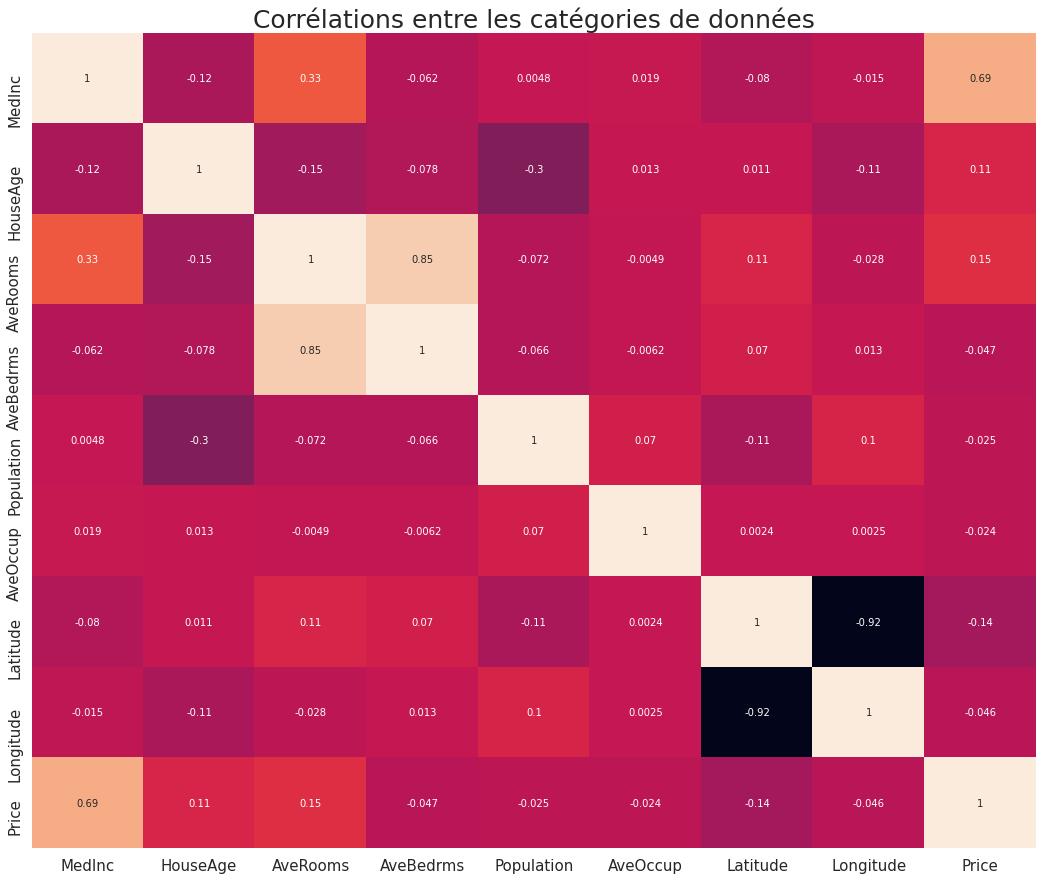

In [ ]:
plt.figure(figsize=(18,15))        #définition de la taille totale du plot
sns.heatmap(dataset.corr(), annot=True, cbar=False)        #seaborn.type_de_plot(dataframe.correlation())
plt.title("Corrélations entre les catégories de données", fontsize=25)  #paramètres du titre affiché
plt.tick_params(labelsize=15)      #réglages graphiques de la barre à droite
plt.show()                         #montrer le plot

Lien entre le prix des biens et le revenu médian d'une zone confirmé

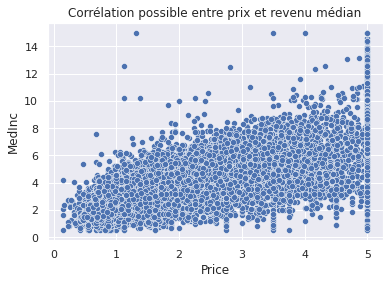

In [ ]:
sns.scatterplot(x=dataset.Price,y=dataset.MedInc)
plt.title("Corrélation possible entre prix et revenu médian")
plt.ylabel("MedInc")
plt.xlabel("Price")
plt.show()

### Recherche des outliers

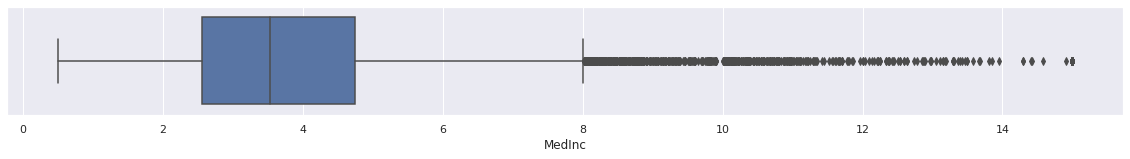

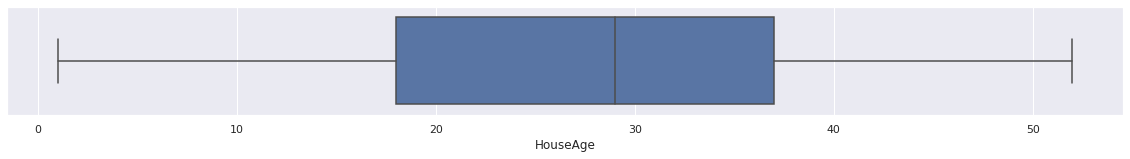

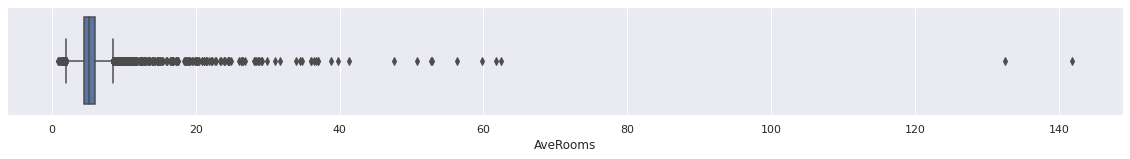

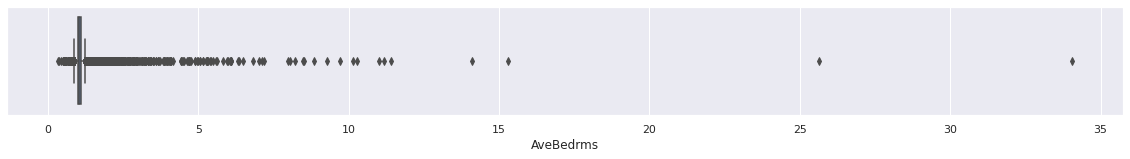

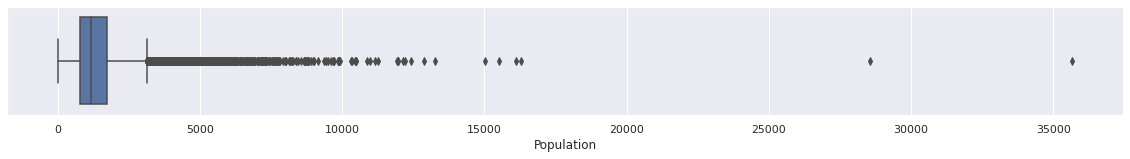

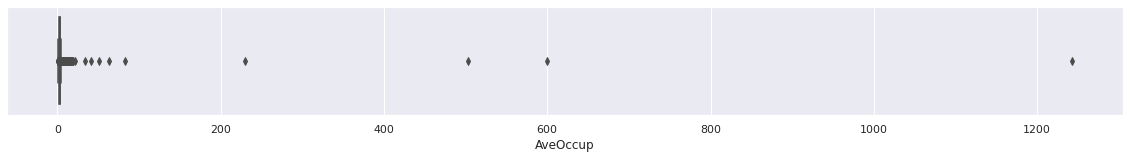

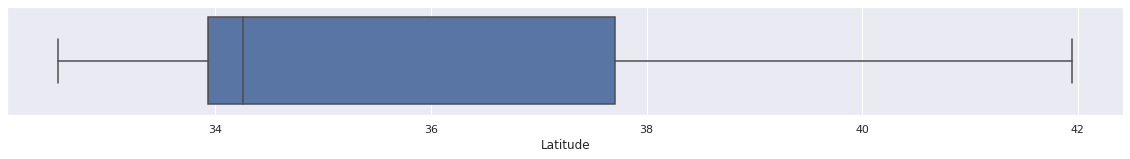

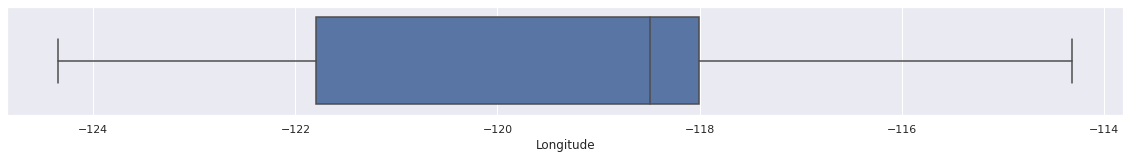

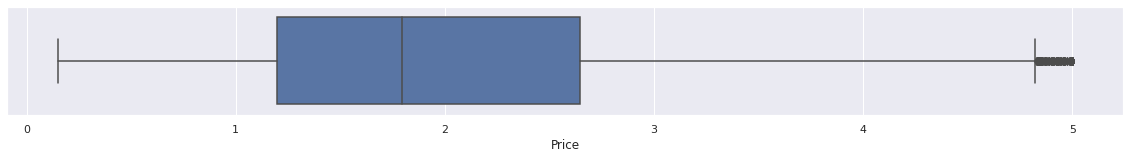

In [ ]:
for col in dataset:
    plt.figure(figsize=(20,2))
    sns.boxplot(dataset[col])
    plt.show()

Population : beaucoup de données atypiques, qui correspondent aux grandes métropoles.
<br>MedInc : Californie = San Francisco = Silicon Valley et autres lieux de richesse.
<br>AveRooms : Los Angeles = Hollywood et autres berceaux à villas. Il y a peut-être quand même des données aberrantes.
<br>AveRooms : Idem AveRooms, jusqu'à 34 chambres, c'est beaucoup, même pour une villa.
<br>AveOccup : Plus de 200 occupants dans un logement, c'est loin d'être standard

## <a id='4'><font color="Green"><center>Pre-processing et choix du modèle</center></font></a>
### Sur données non standardisées

In [ ]:
#récupération des données sans target
X = dataset.iloc[:, 0:-1]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.33,41.00,6.98,1.02,322.00,2.56,37.88,-122.23
1,8.30,21.00,6.24,0.97,2401.00,2.11,37.86,-122.22
2,7.26,52.00,8.29,1.07,496.00,2.80,37.85,-122.24
3,5.64,52.00,5.82,1.07,558.00,2.55,37.85,-122.25
4,3.85,52.00,6.28,1.08,565.00,2.18,37.85,-122.25


In [ ]:
#récupération de la target
y = dataset["Price"]
y.head()

0   4.53
1   3.58
2   3.52
3   3.41
4   3.42
Name: Price, dtype: float64

In [ ]:
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

#test de différents modèles pour trouver le plus adapté
#reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
#fit sur les données
#models, predictions = reg.fit(X_train, X_test, y_train, y_test)

#affichage des résultats
#print(models)

### Sur données standardisées

In [ ]:
#standardisation des données sans target
df_x_stand = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns, index=dataset.index)

#réunion avec la target
df_full_stand = df_x_stand.copy()
df_full_stand["Price"] = dataset["Price"]
df_full_stand.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,2.34,0.98,0.63,-0.15,-0.97,-0.05,1.05,-1.33,4.53
1,2.33,-0.61,0.33,-0.26,0.86,-0.09,1.04,-1.32,3.58
2,1.78,1.86,1.16,-0.05,-0.82,-0.03,1.04,-1.33,3.52
3,0.93,1.86,0.16,-0.05,-0.77,-0.05,1.04,-1.34,3.41
4,-0.01,1.86,0.34,-0.03,-0.76,-0.09,1.04,-1.34,3.42


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_full_stand.iloc[:, 0:-1], df_full_stand["Price"],
                                                    train_size=0.8, random_state=12)

#reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
#models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# print(models)

Légère amélioration, rien de bien fou.
### Sur données standardisées, outliers supprimés

MedInc > 8
<br>AveRooms > 40
<br>AveOccup > 200

In [ ]:
df = dataset.copy()
df = df[df["MedInc"] < 8] #suppression des biens dont le quartier est trop riche (bye bye Hollywood)
df = df[df["AveRooms"] < 40] #suppression des énormes villas
df = df[df["AveOccup"] < 200] #suppression des biens extrêmement occupés

#on vérifie que les filtres ont bien été appliqués
# for col in df:
#     plt.figure(figsize=(20,2))
#     sns.boxplot(df[col])
#     plt.show()

In [ ]:
X = df.iloc[:, 0:-1]

df_x_stand = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns, index=df.index)

df_full_stand = df_x_stand.copy()
df_full_stand["Price"] = dataset["Price"]

X_train, X_test, y_train, y_test = train_test_split(df_full_stand.iloc[:, 0:-1], df_full_stand["Price"],
                                                    train_size=0.8, random_state=12)

#reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
#models, predictions = reg.fit(X_train, X_test, y_train, y_test)
#print(models)

Seul du temps de traitement a été gagné.
## <a id='5'><font color="Green"><center>Modélisation & évaluation</center></font></a>

In [ ]:
#split
X_train, X_test, y_train, y_test = train_test_split(df_full_stand.iloc[:, 0:-1], df_full_stand["Price"],
                                                    train_size=0.8, random_state=12)

#création du modèle (sans hyperparamètres !)
reg = LGBMRegressor()
#ajustement aux données d'entrainement
reg.fit(X_train, y_train)
#prédiction sur les données de test
y_pred = reg.predict(X_test)

#évaluation
print('r2 score: %.2f'% r2_score(y_test, y_pred))
print('Mean squared error: %.2f'% mean_squared_error(y_test, y_pred))
print('Mean absolute error: %.2f'% mean_absolute_error(y_test, y_pred))

r2 score: 0.80
Mean squared error: 0.23
Mean absolute error: 0.32


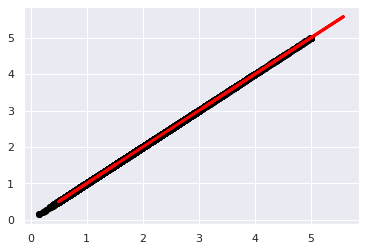

In [ ]:
# Plot des résultats
plt.scatter(y_test, y_test, color='black') #données réelles
plt.plot(y_pred, y_pred, color='red', linewidth=3); #données prédites

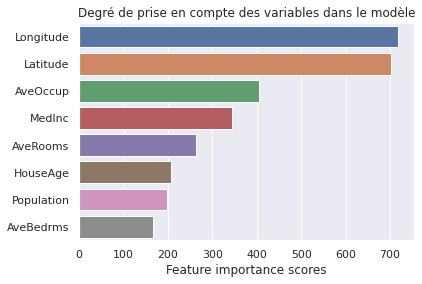

In [ ]:
#affichage des scores d'importance
feature_imp = pd.Series(reg.feature_importances_, index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel("Feature importance scores")
plt.title("Degré de prise en compte des variables dans le modèle")
plt.show()

La localisation a compté pour beaucoup dans le calcul des prix
## <a id='6'><font color="Green"><center>Préparation au déploiement</center></font></a>

In [ ]:
#enregistrement du modèle
import pickle

pickle.dump(reg, open('model.pkl','wb'))

In [ ]:
# Chargement du modèle pour tester
model = pickle.load(open('model.pkl','rb'))
print(model.predict([[2.34,0.98,0.63,-0.15,-0.97,-0.05,1.05,-1.33]]))

## <a id='7'><font color="Green"><center>Deep Learning - Tests</center></font></a>

In [ ]:
# import de toutes les librairies nécessaires

import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model

In [ ]:
# répartion en train / validation / test

def train_validate_test_split(df, train_part=.6, validate_part=.2, test_part=.2, seed=None):
    np.random.seed(seed)
    total_size = train_part + validate_part + test_part
    train_percent = train_part / total_size
    validate_percent = validate_part / total_size
    test_percent = test_part / total_size
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = perm[:train_end]
    validate = perm[train_end:validate_end]
    test = perm[validate_end:]
    return train, validate, test

train_size, valid_size, test_size = (80, 20, 0)
kc_train, kc_valid, kc_test = train_validate_test_split(df, 
                              train_part=train_size, 
                              validate_part=valid_size,
                              test_part=test_size,
                              seed=2017)

In [ ]:
# mise à part du label

kc_y_train = df.loc[kc_train, ["Price"]]
kc_x_train = df.loc[kc_train, :].drop("Price", axis=1)
kc_y_valid = df.loc[kc_valid, ["Price"]]
kc_x_valid = df.loc[kc_valid, :].drop("Price", axis=1)

# taille des datasets
print('Size of training set: ', len(kc_x_train))
print('Size of validation set: ', len(kc_x_valid))
print('Size of test set: ', len(kc_test), '(not converted)')

Size of training set:  13954
Size of validation set:  2990
Size of test set:  2991 (not converted)


In [ ]:
# conversion des datasets en vecteurs

def norm_stats(df1, df2):
    dfs = df1.append(df2)
    minimum = np.min(dfs)
    maximum = np.max(dfs)
    mu = np.mean(dfs)
    sigma = np.std(dfs)
    return (minimum, maximum, mu, sigma)

def z_score(col, stats):
    m, M, mu, s = stats
    df = pd.DataFrame()
    for c in col.columns:
        df[c] = (col[c]-mu[c])/s[c]
    return df

stats = norm_stats(kc_x_train, kc_x_valid)
arr_x_train = np.array(z_score(kc_x_train, stats))
arr_y_train = np.array(kc_y_train)
arr_x_valid = np.array(z_score(kc_x_valid, stats))
arr_y_valid = np.array(kc_y_valid)

print('Training shape:', arr_x_train.shape)
print('Training samples: ', arr_x_train.shape[0])
print('Validation samples: ', arr_x_valid.shape[0])

Training shape: (13954, 8)
Training samples:  13954
Validation samples:  2990


In [ ]:
# création du modèle (simple)

def ch_model(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(300, activation="relu", input_shape=(x_size,)))
    t_model.add(Dense(300, activation="relu"))
    t_model.add(Dense(300, activation="relu"))
    t_model.add(Dense(300, activation="relu"))
    t_model.add(Dense(200, activation="relu"))
    t_model.add(Dense(100, activation="relu"))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

model = ch_model(arr_x_train.shape[1], arr_y_train.shape[1])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               2700      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [ ]:
# création d'un paramètre d'early stopping
# au bout de 20 epochs sans amélioration de la MAE sur le set de validation, l'entraînement s'arrête

keras_callbacks = [EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)]

In [ ]:
# entraînement du modèle

history = model.fit(arr_x_train, arr_y_train,
    batch_size=64,
    epochs=500,
    shuffle=True,
    verbose=2,
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

Epoch 1/500
219/219 - 2s - loss: 0.5496 - mean_absolute_error: 0.5104 - val_loss: 0.3333 - val_mean_absolute_error: 0.4025
Epoch 2/500
219/219 - 1s - loss: 0.3439 - mean_absolute_error: 0.4119 - val_loss: 0.3029 - val_mean_absolute_error: 0.3800
Epoch 3/500
219/219 - 1s - loss: 0.3148 - mean_absolute_error: 0.3913 - val_loss: 0.2950 - val_mean_absolute_error: 0.3658
Epoch 4/500
219/219 - 1s - loss: 0.3043 - mean_absolute_error: 0.3820 - val_loss: 0.3502 - val_mean_absolute_error: 0.3871
Epoch 5/500
219/219 - 1s - loss: 0.3006 - mean_absolute_error: 0.3780 - val_loss: 0.2915 - val_mean_absolute_error: 0.3576
Epoch 6/500
219/219 - 1s - loss: 0.2846 - mean_absolute_error: 0.3658 - val_loss: 0.3385 - val_mean_absolute_error: 0.3778
Epoch 7/500
219/219 - 1s - loss: 0.2869 - mean_absolute_error: 0.3663 - val_loss: 0.2717 - val_mean_absolute_error: 0.3502
Epoch 8/500
219/219 - 1s - loss: 0.2695 - mean_absolute_error: 0.3551 - val_loss: 0.3086 - val_mean_absolute_error: 0.3642
Epoch 9/500
219/

In [ ]:
#impression des meilleurs scores obtenus (càd les plus bas sur ces metrics)

train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE:  0.2631 , Train Loss:  0.1452
Val MAE:  0.3343 , Val Loss:  0.2556


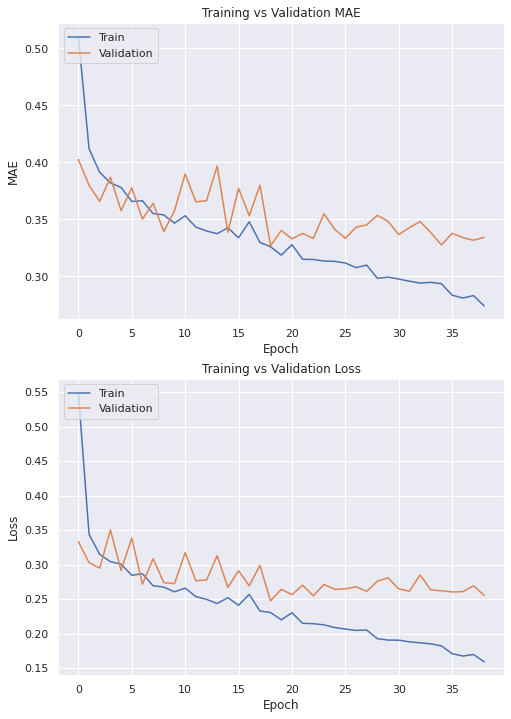

In [ ]:
# plot des metrics pour constater l'overfitting

def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

plot_hist(history.history, xsize=8, ysize=12)

Modèle déséquilibré qui overfit rapidement

In [ ]:
# second modèle, avec dropout et regularizers pour mieux généraliser le modèle

def ch_model_2(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer='nadam',
        metrics=[metrics.mae])
    return(t_model)

model2 = ch_model(arr_x_train.shape[1], arr_y_train.shape[1])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 300)               2700      
_________________________________________________________________
dense_15 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_16 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_17 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_18 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_19 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                

In [ ]:
# entraînement du second modèle

history2 = model2.fit(arr_x_train, arr_y_train,
    batch_size=64,
    epochs=500,
    shuffle=True,
    verbose=2,
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

Epoch 1/500
219/219 - 1s - loss: 0.5042 - mean_absolute_error: 0.4895 - val_loss: 0.3339 - val_mean_absolute_error: 0.3911
Epoch 2/500
219/219 - 1s - loss: 0.3366 - mean_absolute_error: 0.4069 - val_loss: 0.3064 - val_mean_absolute_error: 0.3899
Epoch 3/500
219/219 - 1s - loss: 0.3204 - mean_absolute_error: 0.3938 - val_loss: 0.3712 - val_mean_absolute_error: 0.4418
Epoch 4/500
219/219 - 1s - loss: 0.3050 - mean_absolute_error: 0.3818 - val_loss: 0.3376 - val_mean_absolute_error: 0.3802
Epoch 5/500
219/219 - 1s - loss: 0.2905 - mean_absolute_error: 0.3708 - val_loss: 0.3000 - val_mean_absolute_error: 0.3604
Epoch 6/500
219/219 - 1s - loss: 0.2781 - mean_absolute_error: 0.3619 - val_loss: 0.2840 - val_mean_absolute_error: 0.3608
Epoch 7/500
219/219 - 1s - loss: 0.2832 - mean_absolute_error: 0.3648 - val_loss: 0.2779 - val_mean_absolute_error: 0.3559
Epoch 8/500
219/219 - 1s - loss: 0.2776 - mean_absolute_error: 0.3608 - val_loss: 0.2845 - val_mean_absolute_error: 0.3494
Epoch 9/500
219/

In [ ]:
# on est mieux sur le train, pire sur la val

train_score = model2.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model2.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE:  0.2339 , Train Loss:  0.1102
Val MAE:  0.3509 , Val Loss:  0.281


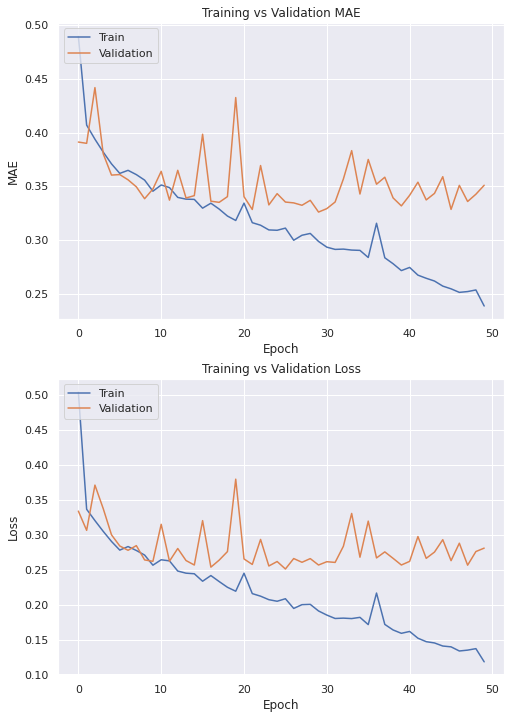

In [ ]:
plot_hist(history2.history, xsize=8, ysize=12)